# ONNX

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
SAVE_DIR = "/content/drive/MyDrive/iMIAP_Project_lifesky"
model_save_name = "mobnetv3s_best_param_f1_focal.pth"
model_save_path = os.path.join(SAVE_DIR, model_save_name)

# Define the output ONNX file path
onnx_model_path = "onnx_focal.onnx"

In [ ]:
!pip install onnx onnxruntime torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import torch.onnx
import onnx
from torchvision import transforms, models, datasets

## ONNX Conversion

In [ ]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load trained model
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 1)  # Single output for binary classification
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()  # Set to evaluation mode

# Define the input dimensions
IMG_SIZE = 224
batch_size = 1  # ONNX usually expects batch size for input

# Create a dummy input with the same shape as model expects
dummy_input = torch.randn(batch_size, 3, IMG_SIZE, IMG_SIZE)

# Export the model to ONNX
torch.onnx.export(
    model,                  # model being run
    dummy_input,            # model input (or a tuple for multiple inputs)
    onnx_model_path,        # where to save the model
    export_params=True,     # store the trained parameter weights
    opset_version=12,       # the ONNX version to use
    do_constant_folding=True,  # whether to execute constant folding
    input_names=['input'],   # the model's input names
    output_names=['output'], # the model's output names
    dynamic_axes={          # variable length axes
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"✅ Model successfully converted to {onnx_model_path}")

Using device: cuda


/tmp/ipython-input-2400563895.py:20: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model successfully converted to onnx_focal.onnx


### Verify the ONNX Model

In [ ]:
# Load and check the ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("✅ ONNX model is valid!")

# Print model input/output information
print("\n📋 Model Input/Output Info:")
for input in onnx_model.graph.input:
    print(f"Input: {input.name}, Shape: {input.type.tensor_type.shape}")

for output in onnx_model.graph.output:
    print(f"Output: {output.name}, Shape: {output.type.tensor_type.shape}")

✅ ONNX model is valid!

📋 Model Input/Output Info:
Input: input, Shape: dim {
  dim_param: "batch_size"
}
dim {
  dim_value: 3
}
dim {
  dim_value: 224
}
dim {
  dim_value: 224
}

Output: output, Shape: dim {
  dim_param: "batch_size"
}
dim {
  dim_value: 1
}



## Test Inference with ONNX Runtime


Saving case_M_20190117105747_0U62368011712547_1_004_001-1_a13_ayy_image0256.jpg to case_M_20190117105747_0U62368011712547_1_004_001-1_a13_ayy_image0256.jpg
🎯 Prediction: Lumen
📊 Confidence: 1.0000


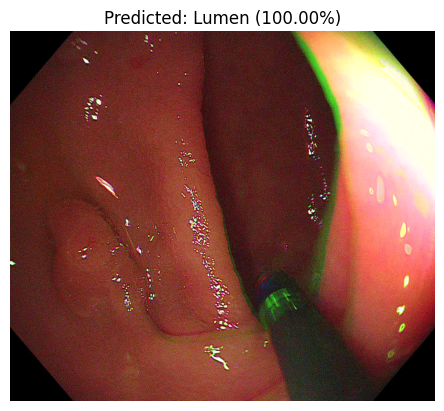

In [ ]:
import onnxruntime as ort
from torchvision import transforms
from google.colab import files
import time

# Create ONNX Runtime session
ort_session = ort.InferenceSession(onnx_model_path)

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor.numpy(), image

# Test with a sample image (upload one first or use a test image)
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Preprocess the image
input_array, original_image = preprocess_image(image_path)

# Run inference with ONNX
start_time = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: input_array}
ort_outputs = ort_session.run(None, ort_inputs)
end_time = time.time()


# Get predictions
outputs = ort_outputs[0]
predictions = torch.nn.functional.softmax(torch.tensor(outputs), dim=1)
confidence, predicted_class = predictions.max(1)

class_names = ['Lumen', 'No Lumen']
print(f"🎯 Prediction: {class_names[predicted_class.item()]}")
print(f"📊 Confidence: {confidence.item():.4f}")

print("Output shape:", outputs[0].shape)
print("Inference time: {:.6f} seconds".format(end_time - start_time))
# Display the image
import matplotlib.pyplot as plt
plt.imshow(original_image)
plt.title(f"Predicted: {class_names[predicted_class.item()]} ({confidence.item():.2%})")
plt.axis('off')
plt.show()

## Compare ONNX vs PyTorch Results (Validation)

In [ ]:
# Compare ONNX and PyTorch outputs to ensure accuracy
def compare_outputs(pytorch_model, onnx_session, test_input):
    # PyTorch inference
    with torch.no_grad():
        pytorch_output = pytorch_model(test_input)
        pytorch_probs = torch.nn.functional.softmax(pytorch_output, dim=1)

    # ONNX inference
    ort_inputs = {onnx_session.get_inputs()[0].name: test_input.numpy()}
    ort_outputs = onnx_session.run(None, ort_inputs)
    onnx_probs = torch.nn.functional.softmax(torch.tensor(ort_outputs[0]), dim=1)

    # Compare
    print(f"PyTorch probs: {pytorch_probs.numpy()}")
    print(f"ONNX probs: {onnx_probs.numpy()}")
    print(f"Max difference: {torch.max(torch.abs(pytorch_probs - onnx_probs)).item()}")

    # They should be very close (difference < 1e-6)
    return torch.allclose(pytorch_probs, onnx_probs, atol=1e-6)

# Test comparison
test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
is_match = compare_outputs(model, ort_session, test_input)
print(f"✅ Outputs match: {is_match}")

PyTorch probs: [[1.]]
ONNX probs: [[1.]]
Max difference: 0.0
✅ Outputs match: True


## Advanced - Quantization (for faster inference)

In [ ]:
# Optional: Quantize the model for even faster inference
from onnxruntime.quantization import quantize_dynamic, QuantType

def quantize_onnx_model(onnx_model_path, quantized_model_path):
    quantize_dynamic(
        onnx_model_path,
        quantized_model_path,
        weight_type=QuantType.QUInt8  # Use QInt8 for GPU, QUInt8 for CPU
    )
    print(f"✅ Quantized model saved to {quantized_model_path}")

# Quantize the model
quantized_model_path = "onnx_focal_quantized.onnx"
quantize_onnx_model(onnx_model_path, quantized_model_path)

# Test quantized model
ort_session_quantized = ort.InferenceSession(quantized_model_path)
ort_inputs = {ort_session_quantized.get_inputs()[0].name: input_array}
ort_outputs_quantized = ort_session_quantized.run(None, ort_inputs)

print("Original vs Quantized comparison:")
print(f"Original output: {ort_outputs[0]}")
print(f"Quantized output: {ort_outputs_quantized[0]}")

✅ Quantized model saved to onnx_focal_quantized.onnx
Original vs Quantized comparison:
Original output: [[-1.3205693]]
Quantized output: [[4.1601686]]


## Download the ONNX Model

In [ ]:
from google.colab import files

# Download the ONNX model
files.download(onnx_model_path)

# Optional: Download quantized model
#files.download(quantized_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>